In [1]:
%load_ext watermark
%watermark -v -m -p pandas,numpy,scipy,faker -g

CPython 3.5.3
IPython 5.1.0

pandas 0.19.2
numpy 1.11.3
scipy 0.19.0
faker n

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.4.0-79-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 92f197794a40b3992f64b8e246184a9e42aa7439


In [2]:
number_people = 10000
number_actions = 1000000
precision = 1

In [3]:
shows = {'title':['Velocity','HD','Punky Heels','Jack Wild','Duendes','Cant Buy Time'],
        'genre':['action','drama','comedy','reality','fantasy','sci-fi'],
        'description':['an action packed thriller about a pregnant woman stuck on a subway car that cannot slow down',
                      '35 year old Mike, struggles to reconnect with his birth family after being diagnosed with a genetic disorder',
                      'a romantic comedy about a young woman trying to find love in the city',
                      'a recent college grad trying to find himself learns the meaning of life while stuck in an alaskan blizzard',
                      'an unknown creature terrorizes the town of Salamanca, will they survive?',
                      'a group of friends gets stuck in a suburban shopping mall as the manifold of time and space collapses around them'
                      ],
        'show_id':[1,2,3,4,5,6]
        }

In [4]:
import pandas as pd

show_df = pd.DataFrame(shows)

In [5]:
show_df

,description,genre,show_id,title
0,an action packed thriller about a pregnant wom...,action,1,Velocity
1,"35 year old Mike, struggles to reconnect with ...",drama,2,HD
2,a romantic comedy about a young woman trying t...,comedy,3,Punky Heels
3,a recent college grad trying to find himself l...,reality,4,Jack Wild
4,an unknown creature terrorizes the town of Sal...,fantasy,5,Duendes
5,a group of friends gets stuck in a suburban sh...,sci-fi,6,Cant Buy Time


In [6]:
from faker import Faker
fake = Faker()
people = {'name': [],
          'sex': [],
          'bday': [],
          'p_id':[]
         }

for i in range(number_people):
    profile = fake.simple_profile(sex=None) 
    people['name'].append(profile['name'])
    people['sex'].append(profile['sex'])
    people['bday'].append(profile['birthdate'])
    people['p_id'].append(i)
    
people_df = pd.DataFrame(people)

In [7]:
from datetime import datetime, date, timedelta

def calculate_age(bday):
    bday = datetime.strptime(bday,'%Y-%m-%d')

    today = date.today()
    return today.year - bday.year - ((today.month, today.day) < (bday.month, bday.day))

people_df['age'] = people_df['bday'].apply(calculate_age)

In [8]:
import numpy as np

def generate_alpha_dict(x, precision=5, num_out=1, beta=True):
    output = {}
    for i in range(x+1):
        if beta:
            output[i] = [precision*np.random.uniform(0.5,1.51, size=[num_out,]),precision]
        else:
            output[i] = precision*np.random.uniform(0.5,1.51, size=[num_out,])
    
    return output

In [9]:
import numpy as np

def per_row_draws(customer_df, draw_func, parameter_func, alpha):
    assert isinstance(customer_df, pd.DataFrame)
    
    output = []
    for i in customer_df.iterrows():
        draw_inputs = parameter_func(i, alpha)
        output.append(draw_func(*draw_inputs))
    
    return output

In [10]:
def find_age_group(row, alpha):
    assert isinstance(alpha, dict)

    age = int(row[1]['age'] / 10)
    while True:
        if age in alpha:
            return alpha[age]
        else:
            age -= 1
        if age < 0:
            return 'alpha_dict broken!'


age_tv_watching_alphas = generate_alpha_dict(10, precision=precision)
people_df['watch_prob'] = per_row_draws(people_df, np.random.beta, find_age_group, age_tv_watching_alphas)

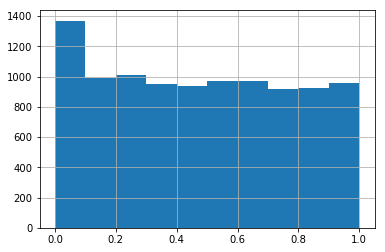

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

people_df.watch_prob.hist()

In [12]:
def find_show_probability(row, alpha_dict):  
    male_dict = alpha_dict[0]
    female_dict = alpha_dict[1]
    gender = row[1]['sex']
    if gender == 'M':
        alpha = male_dict
    elif gender == 'F':
        alpha = female_dict
    else:
        return 'i am outdated and only do binary gender'
    
    age = int(row[1]['age'] / 10)
    while True:
        if age in alpha:
            return [alpha[age]]
        else:
            age -= 1
        if age < 0:
            return 'alpha_dict broken!'

In [13]:
female_alphas = generate_alpha_dict(10, precision=precision, num_out=show_df.shape[0], beta=False)
male_alphas = generate_alpha_dict(10, precision=precision, num_out=show_df.shape[0], beta=False)

alpha = [male_alphas, female_alphas]

people_df['show_prob'] = per_row_draws(people_df, np.random.dirichlet, find_show_probability, alpha)

In [14]:
def create_use_df(customer_df, show_df, size=1000, person_id = 'p_id'):
    behavior_dict = {'show_id':[], 'p_id':[]}
    shows = show_df['show_id'].values
    
    while len(behavior_dict['show_id']) < size:
        person = customer_df[customer_df[person_id] == np.random.choice(customer_df[person_id])] 
        
        if np.random.binomial(1, person.watch_prob.values[0]):
            show_watched = shows[np.where(np.random.multinomial(1, person.show_prob.values[0], size=1)[0])[0][0]]
            behavior_dict['p_id'].append(person.p_id.values[0])
            behavior_dict['show_id'].append(show_watched)
    
    return behavior_dict

In [15]:
behavioral_df = pd.DataFrame(create_use_df(people_df, show_df, size=number_actions))

In [94]:
def create_person_alpha_dict(behavioral_df, show_df, precision=100):
    output = {}
    genre_proclivity = np.random.rand(show_df.shape[0])**2
    print(genre_proclivity)
    shows = show_df['show_id'].values    
        
    grouped_df = pd.merge(behavioral_df, show_df, on='show_id')\
                    .groupby(['p_id','show_id'])['title'].count()\
                    .unstack().reset_index().fillna(0)
    grouped_df['total'] = grouped_df[shows].sum(axis=1)
    grouped_df['total'] = grouped_df['total']/grouped_df['total'].max()
    grouped_df[shows] = grouped_df[shows].apply(lambda x: x/sum(x), axis=1)
    for row in grouped_df.iterrows():
        output[row[1]['p_id']] = [precision*sum((row[1][shows].values**2)*genre_proclivity*4, (row[1]['total']**2)), precision]
        # output[row[1]['p_id']] = [precision*(row[1]['total']*3)**2,precision]
    return output

In [95]:
def signup_probability(row, alpha_dict):
    if row[1]['p_id'] not in alpha_dict:
        return [0.001, 5]
    else:
        return alpha_dict[row[1]['p_id']]

alpha = create_person_alpha_dict(behavioral_df, show_df, precision=1000/precision)
people_df['subscriber_prob'] = per_row_draws(people_df, np.random.beta, signup_probability, alpha)

[ 0.00472012  0.05716067  0.94869851  0.24084681  0.56567342  0.71941358]


[[ 1.          0.98691192]
 [ 0.98691192  1.        ]]


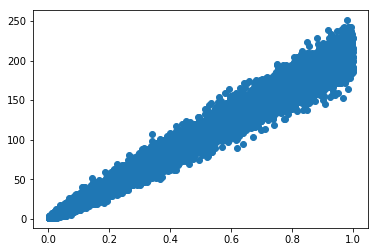

In [96]:
def test_features(x, y):
    print(np.corrcoef(x,y))
    plt.plot(x,y,'o')
    
test_features(people_df[people_df.p_id.isin(behavioral_df.p_id.unique())].watch_prob,
             behavioral_df.groupby('p_id')['show_id'].count().reset_index()['show_id'])

[[ 1.          0.40693671]
 [ 0.40693671  1.        ]]


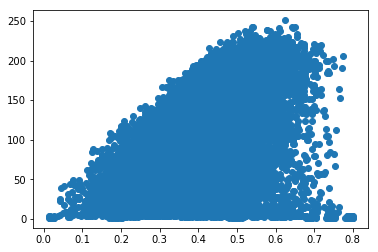

In [97]:
test_features(people_df[people_df.p_id.isin(behavioral_df.p_id.unique())].subscriber_prob,
             behavioral_df.groupby('p_id')['show_id'].count().reset_index()['show_id'])

[[ 1.          0.43239983]
 [ 0.43239983  1.        ]]


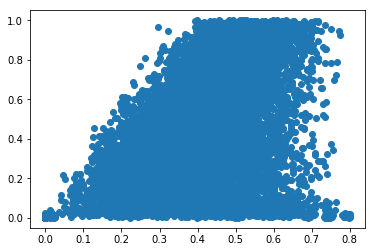

In [98]:
test_features(people_df.subscriber_prob, people_df.watch_prob)

In [108]:
shows = show_df['show_id'].values    

grouped_df = pd.merge(behavioral_df, show_df, on='show_id')\
                .groupby(['p_id','show_id'])['title'].count()\
                .unstack().reset_index().fillna(0)
grouped_df['total'] = grouped_df[shows].sum(axis=1)
grouped_df['total'] = grouped_df['total']/grouped_df['total'].max()
grouped_df[shows] = grouped_df[shows].apply(lambda x: x/sum(x), axis=1)

In [119]:
np.corrcoef(grouped_df[6],
            people_df[people_df.p_id.isin(behavioral_df.p_id.unique())].subscriber_prob)

array([[ 1.        ,  0.25869642],
       [ 0.25869642,  1.        ]])

In [99]:
np.mean(people_df.subscriber_prob)

0.4202082376263792

In [100]:
def create_sub_alpha_dict(people_df):
    output = {}
    for row in people_df.iterrows():
        output[row[1]['p_id']] = row[1]['subscriber_prob']
    return output

def signup_probability(row, alpha_dict):
    assert row[1]['p_id'] in alpha_dict
    return [1, alpha_dict[row[1]['p_id']]]

alpha = create_sub_alpha_dict(people_df)
people_df['subscriber'] = per_row_draws(people_df, np.random.binomial, signup_probability, alpha)

In [101]:
np.mean(people_df.subscriber)

0.4175

In [102]:
people_df.head()

,bday,name,p_id,sex,age,watch_prob,show_prob,subscriber_prob,subscriber
0,1995-03-06,Ronald Parker,0,M,22,0.259556,"[0.262641617676, 0.33744516259, 0.019937907003...",0.139363,0
1,2007-09-08,Jason Wilkinson,1,M,9,0.647592,"[0.386352603226, 0.189916051754, 0.33228244858...",0.441412,1
2,2005-09-25,Antonio Scott,2,M,11,0.834797,"[0.115297493268, 0.511782696982, 0.07493714345...",0.412973,0
3,2008-08-27,David Kelley,3,M,8,0.562002,"[0.408814784828, 0.0463841226788, 0.0365731961...",0.274308,0
4,1993-03-30,Paula Romero,4,F,24,0.911391,"[0.0584781902719, 0.176506590641, 0.1250499217...",0.539003,0


make sure that I have some class imbalance

In [103]:
people_out_df = people_df[['bday','name','p_id','sex','subscriber']]
people_out_df.head()

,bday,name,p_id,sex,subscriber
0,1995-03-06,Ronald Parker,0,M,0
1,2007-09-08,Jason Wilkinson,1,M,1
2,2005-09-25,Antonio Scott,2,M,0
3,2008-08-27,David Kelley,3,M,0
4,1993-03-30,Paula Romero,4,F,0


In [104]:
def change_column(column, change_func, change_rate=0.001):
    output = []
    count = 0
    for i in column:
        if np.random.rand() <= change_rate:
            count += 1
            i = change_func(i)
        output.append(i)
    
    print(count)
    return output

def change_bday(bday):
    bday = datetime.strptime(bday,'%Y-%m-%d')-timedelta(days=365*500)
    bday = bday.strftime('%Y-%m-%d')
    return bday

def change_key(key):
    return key+np.random.randint(number_people,number_people*10)

people_out_df['bday'] = change_column(people_out_df['bday'],change_bday)
behavioral_out_df = behavioral_df.copy()
behavioral_out_df['p_id'] = change_column(behavioral_out_df['p_id'],change_key,change_rate=0.0002)
behavioral_out_df['show_id'] = change_column(behavioral_out_df['show_id'],change_key,change_rate=0.0002)

7


/home/dan-laptop/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


214
204


In [105]:
people_out_df.to_csv('subscribers.csv', index=False)

In [106]:
behavioral_out_df.to_csv('actions.csv', index=False)

In [107]:
show_df.to_csv('shows.csv', index=False)